# Expectation Maximization Algorithm

When looking at a Mixture Model of Gaussians we can use this method to
determine the mixture Model parameters

In [57]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [313]:
# Constants / parameters
# ======================
MODEL_PROBS = [0.6, 0.3, 0.1] # Probability point comes from each of the 3 models.

MODEL_MEAN = [(-2.2, -2.6), (0.5, 0.1), (2.8, 3.1)]
MODEL_COV = [np.array([[0.1, 0.0],[0.0, 0.3]]), np.array([[1.0, -0.2],[-0.2, 0.2]]), np.array([[2.6, 1.1],[1.1, 1.6]])]

NUM_POINTS = 1000

In [314]:
# Ensure we can get repeatable results:
rng = np.random.default_rng(142)

In [315]:
def create_point(model_mean=MODEL_MEAN, model_cov=MODEL_COV, model_probs=MODEL_PROBS, rng=rng):
    model_indecies = np.arange(len(model_probs))
    model_indx = num = np.random.choice(model_indecies, p=model_probs)

    point = rng.multivariate_normal(model_mean[model_indx], model_cov[model_indx])
    return (point, model_indx)
    

In [316]:
points = []
indices = []

for i in range(NUM_POINTS):
    pt, indx = create_point()
    points.append(pt)
    indices.append(indx)

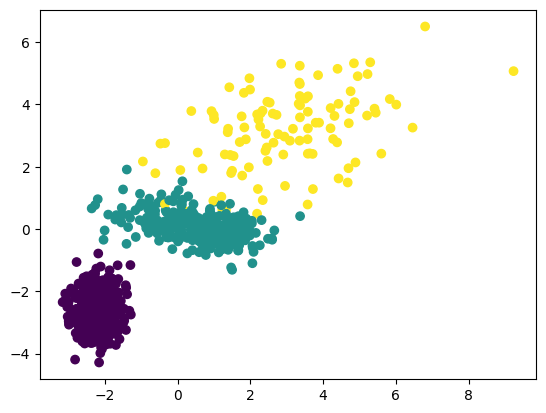

In [317]:
# Plot

x_coords = [pt[0] for pt in points]
y_coords = [pt[1] for pt in points]

plt.scatter(x_coords, y_coords, c=indices, cmap='viridis')

# Now lets implement the EM algorithm.

In [276]:
NUM_MODELS = 3 # Hyper param for algorithm is number of models - here we CORRECTLY assume 3.

In [277]:
# Random point probabilities:
EM_PROBS = rng.dirichlet(np.ones(NUM_MODELS)) # 3 random probs that sum to 1.

# Random means:
rand_vals = rng.uniform(-5, 5, size=(6))
EM_MEAN = [(rand_vals[0], rand_vals[1]), (rand_vals[2], rand_vals[3]), (rand_vals[4], rand_vals[5])]

# Covariances set to I.
EM_COV = [np.eye(2), np.eye(2), np.eye(2)]

# How many times to iterate.
MAX_ITERS = 1

In [278]:
def gaussian_pdf(point, mu, cov):
    """
    calculate the prob density at the point "point"
    in a Gaussian PDF with mean "mu" and covariance "cov"
    """
    mu = np.array(mu) # This is a list of numbers - so needs converting

    d = len(mu)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.sqrt((2*np.pi)**d * det))
    diff = point - mu
    return norm_const * np.exp(-0.5 * diff @ inv @ diff)


In [279]:
# Here we implement the model:

for i in range(MAX_ITERS):
    # E-STEP
    # ======
    working_list = [] # Used for intermediary calcs for each data point.

    for pt in points:
        numerator = []
        denominator = 0
        for indx in range(NUM_MODELS):
            val = EM_PROBS[indx] * gaussian_pdf(pt, EM_MEAN[indx], EM_COV[indx])
            numerator.append(val)
            denominator += val
        working_list.append(np.array(numerator)/denominator)

    
    # M-STEP
    # ======
    N_EST = []         # Number of points in each model (estimated)
    for i in range(NUM_MODELS):
        ith_entries = [entry[i] for entry in working_list]
        N_EST.append(np.sum(ith_entries))



# Kernel Density Estimation

KDE: you choose a fixed bandwidth (smoothing width). Every point contributes a Gaussian “bump” of that width. 
The result is a smooth approximation of the true underlying PDF.

In [318]:
# Gaussian variance matrix:
KDE_COV = np.eye(2)

In [319]:
# The "points" parameter has all points.

kde = []         # The density at each point of the grid.

# Create a grid around [-5,8] x [-5,6]
for x in np.linspace(-5, 8, 51):
    for y in np.linspace(-5, 6, 51):
        density = 0.0
        for pt in points:
            density += gaussian_pdf(pt, (x, y), KDE_COV)
        density = density/NUM_POINTS
        kde.append(((x,y), density))

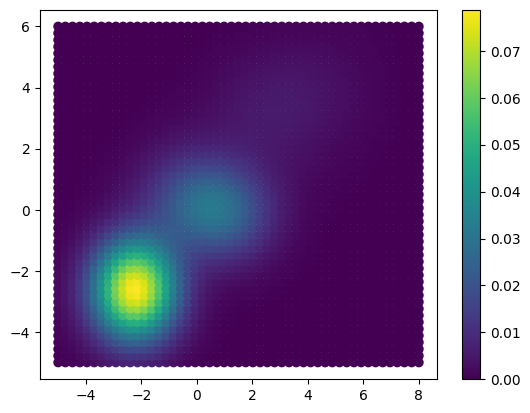

In [320]:
# Show density

x_density = [item[0][0] for item in kde]
y_density = [item[0][1] for item in kde]
densities = [item[1] for item in kde]
densities = np.array(densities)

plt.scatter(x_density, y_density, c=densities, cmap='viridis', vmin=densities.min(), vmax=densities.max())
plt.colorbar()


# Uncomment out code below to see points on top of density.

#x_coords = [pt[0] for pt in points]
#y_coords = [pt[1] for pt in points]

#plt.scatter(x_coords, y_coords)

# Now try K-NN for density estimation

K-NN is usually used to determine the areas of high density.

- k-NN density estimates give you local crowding information, but they’re not a reliable way to count clusters. The “bright spots” you saw depend heavily on 
k
k, and may split or merge arbitrarily.
- To determine the number of clusters, people usually use methods designed for that:
  - Density-based clustering like DBSCAN (uses k-NN distances internally).
  - Mean Shift (follows KDE density peaks).
  - Gaussian Mixture Models (via EM) with model selection (BIC/AIC) to pick the number of clusters.

In [336]:
# K param:
K = 3


def distance(pt1, pt2):
    dist = np.sqrt((pt1 - pt2).T @ (pt1 - pt2))
    return dist.item()


def find_nearest(pt, points, k=K):
    nearest = []
    for tst_pt in points:
        dist = distance(pt, tst_pt)
        if len(nearest) < K:
            nearest.append((tst_pt, dist))
            nearest = sorted(nearest, key=lambda x: x[1])
        else:
            if dist < nearest[-1][1]:
                nearest.pop() # Remove last element
                nearest.append((tst_pt, dist))
                nearest = sorted(nearest, key=lambda x: x[1])

    return nearest


def calculate_density(nearest, num_pts=NUM_POINTS):
    radius = nearest[-1][1]
    area = np.pi * radius**2
    density = len(nearest)/(area * num_pts)
    return density

In [337]:
# Determine density at each of the grid points:

density_grid = []

# Create a grid around [-5,8] x [-5,6]
for x in np.linspace(-5, 8, 51):
    for y in np.linspace(-5, 6, 51):
        grid_pt = np.array([x, y])
        nearest_K = find_nearest(grid_pt, points)
        density = calculate_density(nearest_K)
        density_grid.append((grid_pt, density))


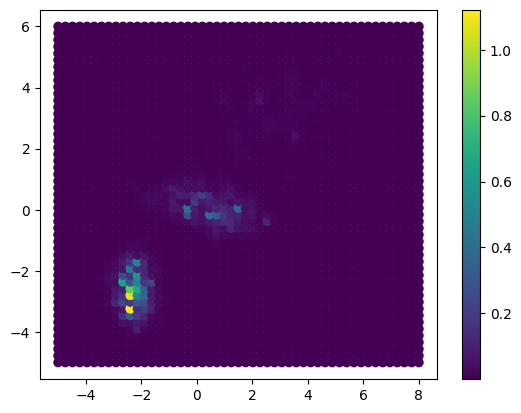

In [338]:
# Show density

x_density = [item[0][0] for item in density_grid]
y_density = [item[0][1] for item in density_grid]
densities = [item[1] for item in density_grid]
densities = np.array(densities)

plt.scatter(x_density, y_density, c=densities, cmap='viridis', vmin=densities.min(), vmax=densities.max())
plt.colorbar()


# Uncomment out code below to see points on top of density.

#x_coords = [pt[0] for pt in points]
#y_coords = [pt[1] for pt in points]

#plt.scatter(x_coords, y_coords)